# Pipeline for High-z Radio Galaxies 03: Radio detection classification with confirmed AGN

## Introduction

Training for classification of sources with and without radio detection in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and those predicted  
to be AGN by the initial Galaxy/AGN classification model (`ML_01.ipynb`).  

Being either AGN or galaxy will be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, brier_score_loss
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, PrecisionRecallDisplay, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [4]:
save_plot_flag         = False
save_model_flag        = True
read_idx_flag          = True
use_AGN_gal_model_flag = False
load_model_flag        = False
use_calibration        = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Z', 'zsp', 'Sint_LOFAR', 'Sint_LOFAR_AB', 'W1mag', 'W2mag', 'spCl', 
                      'num_imputed', 'radio_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Load previous model to create labels for unknown sources (in general, do not use this).

In [8]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index
final_indices     = confirmed_indices.union(unknown_indices)  # all

In [9]:
print(f'There are {np.sum(full_catalog_df.loc[:, "is_gal"] == 1):,} confirmed galaxies in this dataset.')

There are 68,196 confirmed galaxies in this dataset.


In [10]:
if use_AGN_gal_model_flag:
    AGN_gal_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # From ML_16.ipynb

In [11]:
if use_AGN_gal_model_flag:
    new_labels_train   = pyc.predict_model(AGN_gal_clf, data=full_catalog_df,\
                                           probability_threshold=gv.AGN_thresh,\
                                           raw_score=True).loc[:, 'Score_1']

In [12]:
if use_AGN_gal_model_flag:
    full_catalog_df['class'] = new_labels_train.copy()

In [13]:
if use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_gal'] == 1, 0)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(full_catalog_df.loc[:, 'is_AGN'] == 1, 1)

#### Select only confirmed and highly likely galaxies

In [14]:
if use_AGN_gal_model_flag:
    AGN_threshold = 0.95
    gal_threshold = 0.05

In [15]:
if use_AGN_gal_model_flag:
    filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)
    filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] < gal_threshold) & (full_catalog_df.loc[:, 'class'] > 0.00)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)

In [16]:
if not use_AGN_gal_model_flag:
    full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

In [17]:
full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

In [18]:
target_feat = 'LOFAR_detect'

## Possible correlations

In [19]:
print(full_catalog_df.columns.to_list())

['band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4', 'class']


---

Create target

In [20]:
full_catalog_df.loc[:, target_feat] = full_catalog_df.loc[:, target_feat].astype(int)

In [21]:
full_catalog_df.columns

Index(['band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN',
       'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag',
       'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i',
       'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4',
       'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3',
       'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3',
       'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4',
       'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K',
       'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4',
       'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3',
       'W2_W4', 'W3_W4', 'class'],
      dtype='object')

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`class == 1`)

In [22]:
filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df   = full_catalog_df.loc[filter_known_spec]
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   'class', use_calibration=use_calibration)
if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt')
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt')
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt')  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt')  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt')
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt')
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
print('Shape of used data in HETDEX')
print('-' * 60)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 60)
print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (118734, 86)
Data for Modeling (Train, Test, and Calibration): (94987, 86)
Training data:                                    (75989, 86)
Testing data:                                     (9499, 86)
Calibration data:                                 (9499, 86)
Validation data:                                  (23747, 86)
------------------------------------------------------------



In [23]:
full_catalog_df.columns

Index(['band_num', 'LOFAR_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN',
       'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag',
       'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i',
       'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4',
       'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3',
       'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3',
       'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4',
       'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K',
       'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4',
       'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3',
       'W2_W4', 'W3_W4', 'class'],
      dtype='object')

In [24]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_gal'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_gal'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_gal'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'is_gal'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_gal'] == 1)]

In [25]:
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, target_feat] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_gal"]):,} elements,\n' +\
         f'{n_is_gal:,} of them are marked as galaxies, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 68,196 elements,
68,196 of them are marked as galaxies, and, from them, 9,853 have confirmed radio detection.


Remove intermediate targets

In [26]:
cols_to_discard_classes = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'class', 'is_str']
full_catalog_df = full_catalog_df.drop(columns=cols_to_discard_classes)
train_test_df   = train_test_df.drop(columns=cols_to_discard_classes)
train_df        = train_df.drop(columns=cols_to_discard_classes)
test_df         = test_df.drop(columns=cols_to_discard_classes)
calibration_df  = calibration_df.drop(columns=cols_to_discard_classes)
validation_df   = validation_df.drop(columns=cols_to_discard_classes)

---

In [27]:
print('Final shape of used data')
print('-' * 65)
print('(Confirmed galaxies)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 65)

Final shape of used data
-----------------------------------------------------------------
(Confirmed galaxies)
--------------------------------------------------
Full confirmed dataset size:        (68196, 80)
Data for Modeling (Train and Test): (54557, 80)
Training data:                      (43645, 80)
Testing data:                       (5456, 80)
Calibration data:                   (5456, 80)
Validation data:                    (13639, 80)
-----------------------------------------------------------------


---

## Use Correlation matrix to discard some features

In [28]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [29]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [30]:
rsd_vals

LOFAR_detect    243.945298
z_y             146.639076
i_z             102.049558
i_y              73.624670
y_W2             73.354318
r_i              66.262000
g_r              64.931422
H_W3             63.445407
z_W2             53.291970
r_z              52.468130
r_y              47.079439
W1_W3            46.277460
J_W3             45.644314
i_W2             45.514710
y_W1             44.836625
g_i              41.675496
y_J              41.172153
r_W2             40.079592
g_z              37.824809
y_H              37.170252
z_W1             37.061172
g_y              36.312263
J_H              35.932162
z_J              35.834056
i_W1             34.709583
r_W1             34.328856
i_J              34.279611
y_W3             33.721017
r_J              33.318814
y_K              33.091382
z_H              32.677601
W2_W3            32.511405
i_H              31.599055
H_K              31.373807
r_H              31.234574
g_W2             30.807930
z_W3             30.400355
z

In [31]:
correlation    = norm_train_test_df.corr()

In [32]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [33]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [34]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [35]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [36]:
list_drop_corr

['g_H',
 'r_H',
 'gmag',
 'i_H',
 'rmag',
 'y_H',
 'z_H',
 'imag',
 'ymag',
 'g_K',
 'zmag',
 'r_K',
 'J_W1',
 'J_W2',
 'W1mproPM',
 'W2mproPM',
 'i_K',
 'z_K',
 'y_K',
 'g_W4',
 'g_W1',
 'r_W4',
 'J_W3',
 'r_W1',
 'i_W4',
 'K_W1',
 'Jmag',
 'K_W2',
 'J_W4',
 'y_W4',
 'z_W4',
 'g_W3',
 'W2_W4',
 'r_W3',
 'W2_W3',
 'i_W1',
 'W1_W4',
 'W3mag',
 'i_W3',
 'Hmag',
 'H_W1',
 'y_W3',
 'y_W1',
 'z_W3',
 'z_W1',
 'i_J',
 'J_K',
 'g_z',
 'g_J',
 'z_J',
 'r_J',
 'g_y',
 'K_W4',
 'H_W4',
 'K_W3',
 'i_W2',
 'H_W2',
 'r_z',
 'band_num',
 'g_i',
 'r_W2']

In [37]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [38]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [39]:
corr_discard = norm_train_test_discard.corr()

In [40]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

LOFAR_detect  LOFAR_detect    1.000000
y_W2          z_W2            0.749708
y_J           y_W2            0.734840
r_i           r_y             0.710945
y_J           W1_W3           0.691407
z_y           i_y             0.682767
i_y           r_y             0.638970
Kmag          H_K             0.598745
z_W2          g_W2            0.573743
H_K           W1_W3           0.565203
g_W2          r_y             0.560503
z_W2          y_J             0.558650
Kmag          H_W3            0.536328
g_r           g_W2            0.517319
i_z           i_y             0.508523
dtype: float64

Text(1052.0930609538775, 0.5, 'feature')

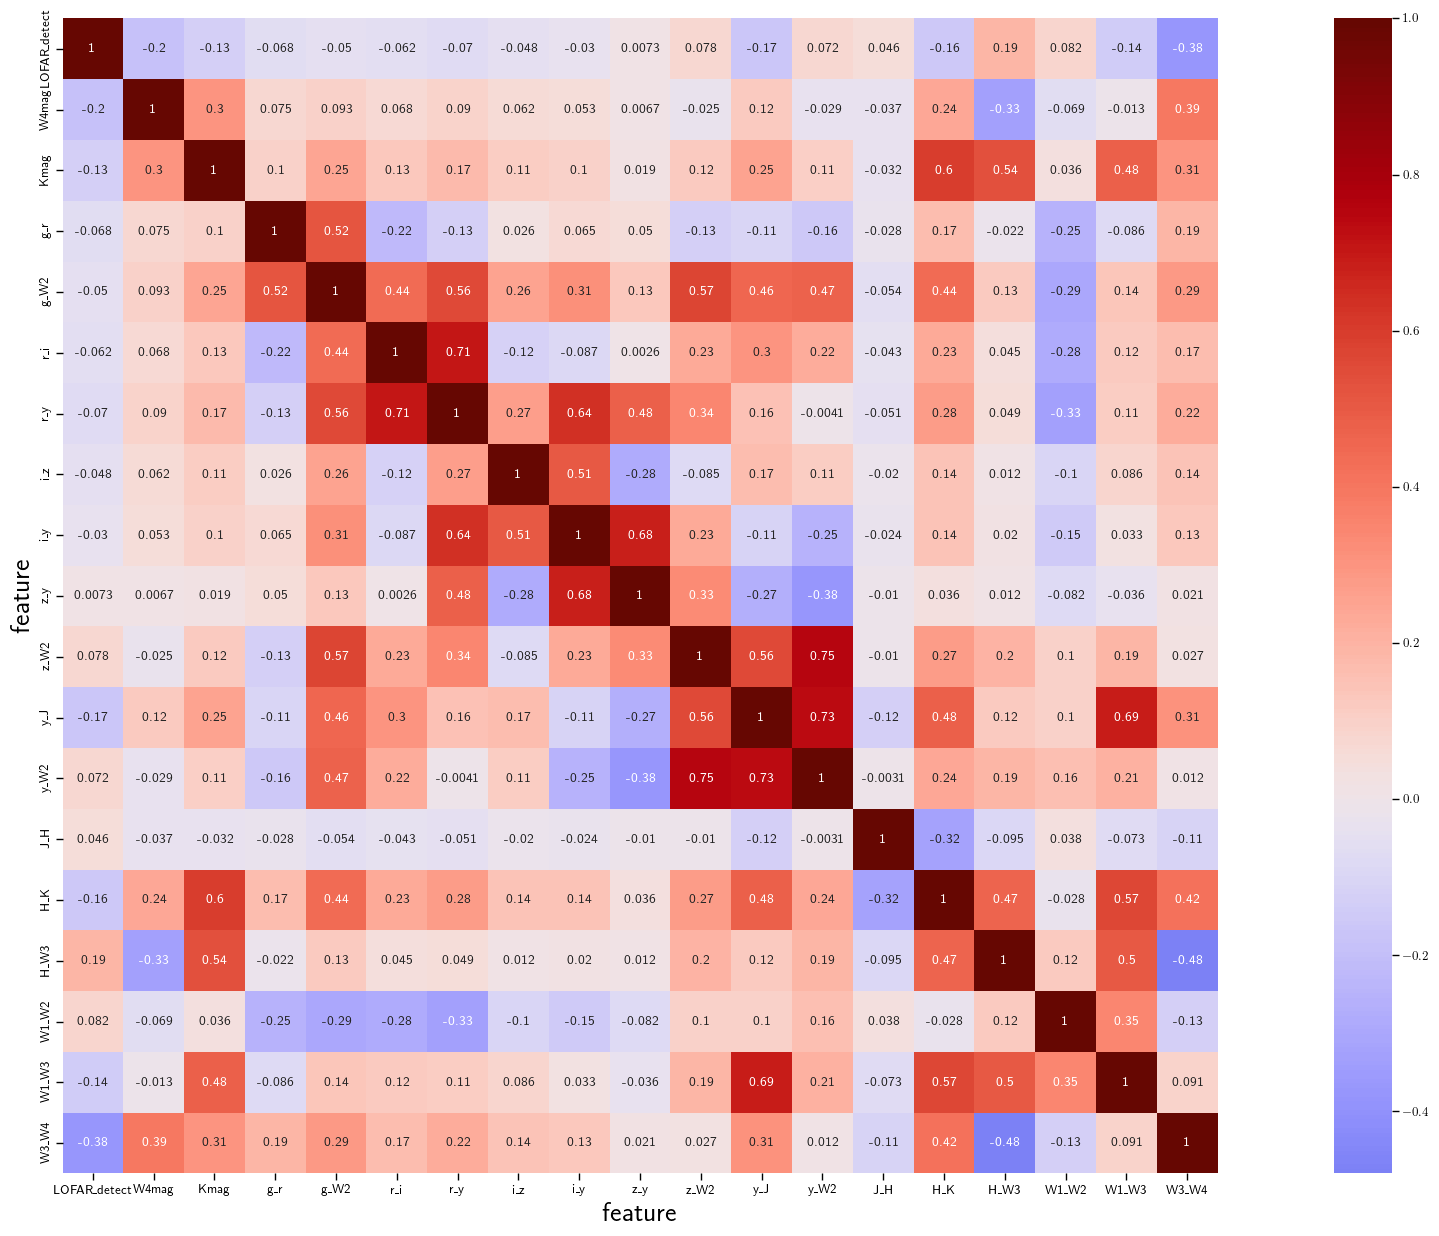

In [41]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [42]:
norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [43]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [44]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y           
H_K    H_K             1.000000
H_W3   H_K             0.470246
       W3_W4           0.424400
J_H    H_K             0.423951
r_y    r_i             0.263859
g_r    g_W2            0.233683
r_i    r_y             0.223666
W3_W4  LOFAR_detect    0.213981
J_H    y_J             0.203715
H_W3   y_J             0.202259
       W1_W3           0.200934
H_K    y_J             0.198852
H_W3   LOFAR_detect    0.195377
W1_W3  y_J             0.184209
       Kmag            0.181957
H_W3   Kmag            0.174256
y_W2   z_W2            0.172510
r_y    i_y             0.172497
       y_J             0.171539
W1_W3  H_K             0.154950
dtype: float64

In [45]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [46]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [47]:
list_drop_pps = []

In [48]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [49]:
list_drop_pps

[]

In [50]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [51]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [52]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W3_W4,LOFAR_detect,0.213981,classification,True,weighted F1,0.793563,0.837737,DecisionTreeClassifier()
1,H_W3,LOFAR_detect,0.195377,classification,True,weighted F1,0.793563,0.833896,DecisionTreeClassifier()
2,W4mag,LOFAR_detect,0.110323,classification,True,weighted F1,0.793563,0.816338,DecisionTreeClassifier()
3,H_K,LOFAR_detect,0.078010,classification,True,weighted F1,0.793563,0.809667,DecisionTreeClassifier()
4,J_H,LOFAR_detect,0.068915,classification,True,weighted F1,0.793563,0.807790,DecisionTreeClassifier()
5,Kmag,LOFAR_detect,0.058340,classification,True,weighted F1,0.793563,0.805607,DecisionTreeClassifier()
6,W1_W2,LOFAR_detect,0.012613,classification,True,weighted F1,0.793563,0.796167,DecisionTreeClassifier()
7,g_r,LOFAR_detect,0.000000,classification,True,weighted F1,0.793563,0.770526,DecisionTreeClassifier()
8,g_W2,LOFAR_detect,0.000000,classification,True,weighted F1,0.793563,0.767186,DecisionTreeClassifier()
9,r_i,LOFAR_detect,0.000000,classification,True,weighted F1,0.793563,0.765127,DecisionTreeClassifier()


In [53]:
print(f'{len(full_catalog_df):,}')

68,196


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [54]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [55]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards no features.

In [56]:
exp_radio = pyc.setup(data                     = train_df,
                      test_data                = test_df,
                      target                   = target_feat,
                      session_id               = gv.seed,
                      silent                   = True,
                      feature_selection        = False,
                      feature_selection_method = 'boruta',
                      data_split_stratify      = True,
                      numeric_features         = final_feats,
                      ignore_features          = feats_2_discard,
                      transformation           = True,
                      transformation_method    = 'yeo-johnson',
                      n_jobs                   = 12,
                      normalize                = True,
                      normalize_method         = 'zscore',
                      use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,LOFAR_detect
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(43645, 80)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [57]:
pyc.get_config('X').columns

Index(['W4mag', 'Kmag', 'g_r', 'g_W2', 'r_i', 'r_y', 'i_z', 'i_y', 'z_y',
       'z_W2', 'y_J', 'y_W2', 'J_H', 'H_K', 'H_W3', 'W1_W2', 'W1_W3', 'W3_W4'],
      dtype='object')

In [58]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


Add F_beta score ($\beta = 1.1$).

In [59]:
pyc.add_metric('f_beta', 'F_score', gf.f_beta, greater_is_better=True)

Name                                             F_score
Display Name                                     F_score
Score Function       <function f_beta at 0x7fd8a0745280>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [58]:
pyc.models(internal=True).loc['catboost']['Tune Grid'].keys()

dict_keys(['eta', 'depth', 'n_estimators', 'random_strength', 'l2_leaf_reg'])

In [59]:
pyc.models(internal=True).loc['xgboost']['Tune Grid'].keys()

dict_keys(['learning_rate', 'n_estimators', 'subsample', 'max_depth', 'colsample_bytree', 'min_child_weight', 'reg_alpha', 'reg_lambda', 'scale_pos_weight'])

In [60]:
pyc.models(internal=True).loc['rf']['Tune Grid'].keys()

dict_keys(['n_estimators', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'criterion', 'class_weight', 'min_samples_split', 'min_samples_leaf'])

In [61]:
pyc.models(internal=True).loc['et']['Tune Grid'].keys()

dict_keys(['n_estimators', 'criterion', 'max_depth', 'min_impurity_decrease', 'max_features', 'bootstrap', 'min_samples_split', 'min_samples_leaf', 'class_weight'])

In [62]:
pyc.models(internal=True).loc['gbc']['Tune Grid'].keys()

dict_keys(['n_estimators', 'learning_rate', 'subsample', 'min_samples_split', 'min_samples_leaf', 'max_depth', 'min_impurity_decrease', 'max_features'])

In [60]:
metric_2_sort         = 'Recall'
final_selection_clf   = ['rf', 'catboost', 'xgboost', 'et', 'gbc', 'dummy']  # lightgbm is selected to be base learner.
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm,dt)
n_models              = 5
top_model_radio = pyc.compare_models(n_select = n_models,
                                     include  = final_selection_clf,
                                     sort     = metric_2_sort)  # 1:15 hour for used_models_clf
# top_model_radio = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_2_sort)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score,TT (Sec)
rf,Random Forest Classifier,0.8838,0.7637,0.2819,0.7609,0.4110,0.3614,0.4169,0.3939,1.2350
catboost,CatBoost Classifier,0.8835,0.7809,0.2806,0.7590,0.4095,0.3598,0.4153,0.3924,1.8430
xgboost,Extreme Gradient Boosting,0.8815,0.7675,0.2776,0.7355,0.4030,0.3518,0.4038,0.3864,9.0990
et,Extra Trees Classifier,0.8823,0.7600,0.2731,0.7528,0.4005,0.3508,0.4069,0.3835,0.2990
gbc,Gradient Boosting Classifier,0.8829,0.7825,0.2649,0.7739,0.3944,0.3465,0.4083,0.3769,1.7130
dummy,Dummy Classifier,0.8559,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0160


Thus, we will select `rf` as meta learner.

Thus, we stack the models.

In [61]:
# base_models = top_model_radio[0:1] + top_model_radio[2:]
# meta_model  = top_model_radio[1]
base_models = top_model_radio[1:]
meta_model  = top_model_radio[0]

In [62]:
stacked_model_radio = pyc.stack_models(estimator_list = base_models,
                                       meta_model     = meta_model,
                                       optimize       = metric_2_sort,
                                       restack        = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.8841,0.7646,0.2878,0.7573,0.4171,0.3668,0.4202,0.4000
1,0.8825,0.7694,0.2830,0.7417,0.4097,0.3586,0.4104,0.3930
2,0.8811,0.7695,0.2782,0.7292,0.4028,0.3511,0.4018,0.3863
3,0.8756,0.7402,0.2385,0.7009,0.3559,0.3050,0.3600,0.3400
4,0.8816,0.7737,0.2639,0.7545,0.3910,0.3419,0.4005,0.3739
5,0.8838,0.7779,0.2814,0.7629,0.4111,0.3616,0.4175,0.3939
6,0.8811,0.7736,0.2734,0.7350,0.3986,0.3476,0.4005,0.3820
7,0.8877,0.7633,0.3148,0.7704,0.4470,0.3965,0.4461,0.4298
8,0.8852,0.7620,0.2734,0.7963,0.4071,0.3599,0.4237,0.3890


In [62]:
# catboost_tune_grid          = pyc.models(internal=True).loc['catboost']['Tune Grid']
# catboost_tune_grid['depth'] = [4, 5, 6, 7, 8, 9, 10, 11]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [63]:
# tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
#                                  early_stopping   = True,
#                                  optimize         = metric_2_sort,
#                                  search_library   = 'tune-sklearn',
#                                  search_algorithm = 'bayesian',
#                                  choose_better    = True,
#                                  custom_grid      = catboost_tune_grid)  # 1h30
tuned_radio_clf = pyc.tune_model(estimator        = stacked_model_radio,
                                 early_stopping   = True,
                                 optimize         = metric_2_sort,
                                 search_library   = 'tune-sklearn',
                                 search_algorithm = 'bayesian',
                                 choose_better    = True)  # 1h30

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
Fold,,,,,,,,
0,0.7521,0.7878,0.6502,0.3218,0.4305,0.2945,0.3243,0.4448
1,0.7588,0.7899,0.6598,0.3309,0.4408,0.3080,0.3378,0.4551
2,0.7567,0.7862,0.6232,0.3221,0.4247,0.2898,0.3151,0.4380
3,0.7423,0.7678,0.5914,0.3000,0.3981,0.2558,0.2796,0.4108
4,0.7569,0.7888,0.6375,0.3250,0.4305,0.2961,0.3233,0.4442
5,0.7440,0.7934,0.6502,0.3132,0.4227,0.2833,0.3145,0.4373
6,0.7550,0.7798,0.6137,0.3185,0.4193,0.2833,0.3078,0.4323
7,0.7573,0.7885,0.6343,0.3249,0.4297,0.2954,0.3221,0.4433
8,0.7660,0.7819,0.6121,0.3313,0.4299,0.2988,0.3211,0.4424


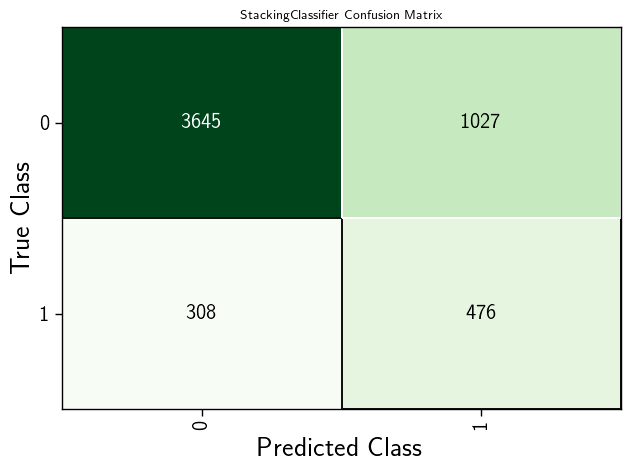

In [64]:
pyc.plot_model(tuned_radio_clf, plot='confusion_matrix')

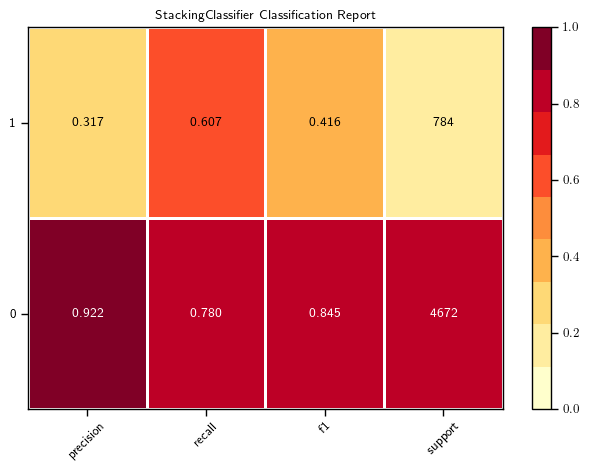

In [65]:
pyc.plot_model(tuned_radio_clf, plot='class_report')

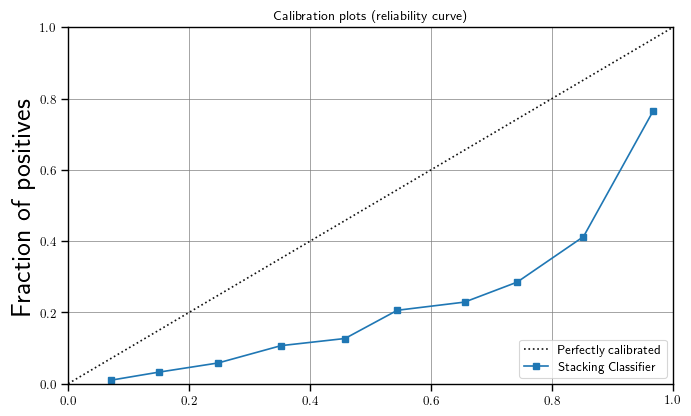

In [66]:
pyc.plot_model(tuned_radio_clf, plot='calibration')

In [79]:
# pyc.plot_model(tuned_radio_clf.estimators_[0], plot='feature_all')

In [67]:
pyc.plot_model(tuned_radio_clf.final_estimator_, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,gini
max_depth,6
max_features,0.42799939792816927
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,3.008698010504669e-06
min_impurity_split,None


In [68]:
pyc.plot_model(tuned_radio_clf.final_estimator, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,gini
max_depth,6
max_features,0.42799939792816927
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,3.008698010504669e-06
min_impurity_split,None


In [69]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [70]:
pyc.predict_model(tuned_radio_clf, data=test_df, probability_threshold=gv.naive_radio_thresh,\
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7553152493,0.7730561028,0.6071428571,0.3166999335,0.4162658505,0.2803439287,0.3041161245,0.4290842116


,Score_0,Score_1
count,5456.000000,5456.000000
mean,0.596911,0.403089
std,0.210218,0.210218
min,0.014964,0.023835
25%,0.481519,0.251216
50%,0.621185,0.378815
75%,0.748784,0.518481
max,0.976165,0.985036


In [71]:
test_prediction_clf = pyc.predict_model(tuned_radio_clf, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7553152493,0.7730561028,0.6071428571,0.3166999335,0.4162658505,0.2803439287,0.3041161245,0.4290842116


In [72]:
final_radio_clf = pyc.finalize_model(tuned_radio_clf)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [73]:
pyc.predict_model(final_radio_clf, probability_threshold=gv.naive_radio_thresh,
                  raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7553152493,0.7730561028,0.6071428571,0.3166999335,0.4162658505,0.2803439287,0.3041161245,0.4290842116


,Score_0,Score_1
count,5456.000000,5456.000000
mean,0.596911,0.403089
std,0.210218,0.210218
min,0.014964,0.023835
25%,0.481519,0.251216
50%,0.621185,0.378815
75%,0.748784,0.518481
max,0.976165,0.985036


In [74]:
if save_model_flag:
    pyc.save_model(final_radio_clf, gv.models_path + gv.radio_galaxies_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [59]:
if load_model_flag:
    final_radio_clf = pyc.load_model(gv.models_path + gv.radio_galaxies_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [75]:
base_models_names = gf.get_base_estimators_names(final_radio_clf)
base_models       = gf.get_base_estimators_models(final_radio_clf)

In [76]:
print('Running data pre-processing:\n')
extended_data_radio_df = gf.preprocess_data(final_radio_clf, validation_df, base_models_names)

Running data pre-processing:



In [77]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_radio_clf, extended_data_radio_df)

In [78]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_radio_df)

In [79]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [80]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for catboost...
Calculating for xgboost...
Calculating for et...
Calculating for gbc...


catboost            xgboost                 et                gbc  \
    Feature Importance Feature Importance Feature Importance Feature   
0     W1_W3  17.033816   W3_W4  46.067944   W1_W3   8.908945   W3_W4   
1     W1_W2  11.098570   W1_W3   6.290230   W1_W2   7.876319   W1_W3   
2      z_W2   7.556322   W4mag   5.454565    z_W2   7.337958   W1_W2   
3      g_W2   7.243238    H_W3   4.878945    y_W2   7.305010    H_W3   
4       g_r   6.744984    y_W2   4.205412    g_W2   7.023085    z_W2   
5      y_W2   6.058723   W1_W2   3.928598     y_J   6.514973    y_W2   
6       y_J   5.569204    z_W2   3.220216     i_z   6.251880    g_W2   
7      H_W3   5.339830    g_W2   3.184344     i_y   6.169531   W4mag   
8       i_z   5.325518    Kmag   2.608448     r_i   6.152962     r_y   
9     W3_W4   4.933936     y_J   2.581805     z_y   6.028685     i_y   
10      r_y   4.486876     g_r   2.444912     r_y   5.955752     r_i   
11      r_i   4.431901     i_z   2.420662     g_r   5.924454     H_K   
12      i_y   4.369613     r_y   2.334686   W3_W4   5.289292     z_y   
13      z_y   4.082277     i_y   2.256118    H_W3   4.721173     y_J   
14      J_H   2.151332     r_i   2.234686   W4mag   4.106033     g_r   
15      H_K   1.852613     z_y   2.206637    Kmag   1.646611     i_z   
16     Kmag   1.410568     H_K   1.862245     H_K   1.486990    Kmag   
17    W4mag   0.310682     J_H   1.819550     J_H   1.300347     J_H   

               
   Importance  
0   52.786950  
1   14.616550  
2    9.195354  
3    8.552607  
4    3.827048  
5    3.630742  
6    2.494203  
7    1.074216  
8    0.912683  
9    0.500740  
10   0.487123  
11   0.432083  
12   0.308934  
13   0.294972  
14   0.285852  
15   0.267258  
16   0.261290  
17   0.071394

In [81]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,gbc,61.752794,61.752794
1,catboost,12.387429,74.140224
2,W3_W4,7.999420,82.139643
3,et,6.079352,88.218995
4,H_W3,2.760542,90.979537
5,xgboost,1.966409,92.945946
6,W1_W3,1.900896,94.846842
7,y_J,1.507361,96.354203
8,g_W2,0.869300,97.223502
9,W1_W2,0.609645,97.833147


In [82]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)#.drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
W3_W4,42.4355,42.4355
W1_W3,56.1378,13.7024
H_W3,65.2243,9.0864
W1_W2,73.4432,8.2189
z_W2,77.5471,4.1039
y_W2,81.4561,3.9090
g_W2,85.2525,3.7964
y_J,88.0787,2.8262
r_y,89.8710,1.7923


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W3_W4	42.435
W1_W3	13.702
H_W3	9.086
W1_W2	8.219
z_W2	4.104
y_W2	3.909
g_W2	3.796
y_J	2.826
r_y	1.792
g_r	1.620
r_i	1.515
i_z	1.472
i_y	1.465
z_y	1.371
W4mag	1.066
H_K	0.644
Kmag	0.497
J_H	0.478


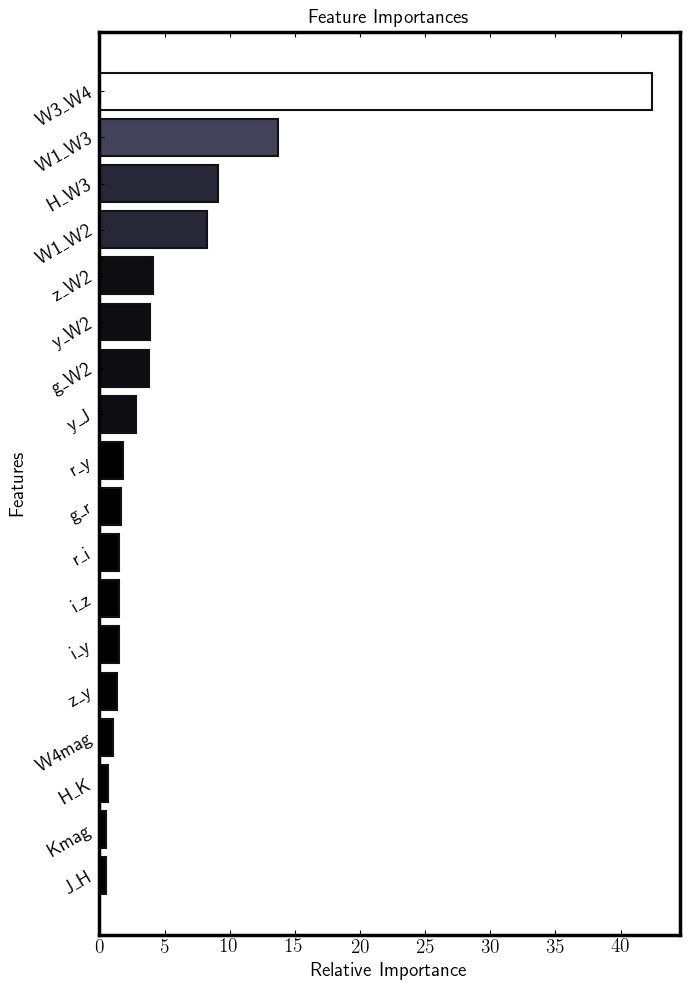

In [83]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_radio_detect_05.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [84]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_radio_clf, 'gbc', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,gbc,catboost,xgboost,et,gbc
n_estimators,17,NaN,100.0000,100.0000,100.0000
min_samples_split,10,NaN,NaN,2.0000,2.0000
min_samples_leaf,3,NaN,NaN,1.0000,1.0000
max_depth,6,NaN,6.0000,NaN,3.0000
min_impurity_decrease,0.0000,NaN,NaN,0.0000,0.0000
max_features,0.4280,NaN,NaN,auto,None
learning_rate,NaN,0.0517,0.3000,NaN,0.1000
depth,NaN,6.0000,NaN,NaN,NaN
random_strength,NaN,1.0000,NaN,NaN,NaN
l2_leaf_reg,NaN,3.0000,NaN,NaN,NaN


---

In [85]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 43,645
Size of test set is  5,456


#### Calculate optimal threshold for classification

In [86]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=gv.naive_radio_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8033909955,0.8457752254,0.7220985692,0.3992967033,0.5142371922,0.4035310404,0.4313766416,0.5286986828


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7553152493,0.7730561028,0.6071428571,0.3166999335,0.4162658505,0.2803439287,0.3041161245,0.4290842116


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7938669648,0.8333998307,0.7016180405,0.3821386441,0.4947888589,0.3791350485,0.4067657286,0.5090481043


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7562316716,0.7892781388,0.6309677419,0.3189823875,0.4237435009,0.2897153157,0.3168360629,0.4373935163


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.7518146492,0.7869776776,0.6417165669,0.3253225398,0.4317609535,0.2941091325,0.3218951712,0.4456147850


#### Naive threshold metrics.

In [87]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [88]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [89]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.5287,0.4314,0.3993,0.7221
Test,0.4291,0.3041,0.3167,0.6071
Train+Test,0.5090,0.4068,0.3821,0.7016
Calibration,0.4374,0.3168,0.3190,0.6310
Validation,0.4456,0.3219,0.3253,0.6417


#### Calibration curve

In [90]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

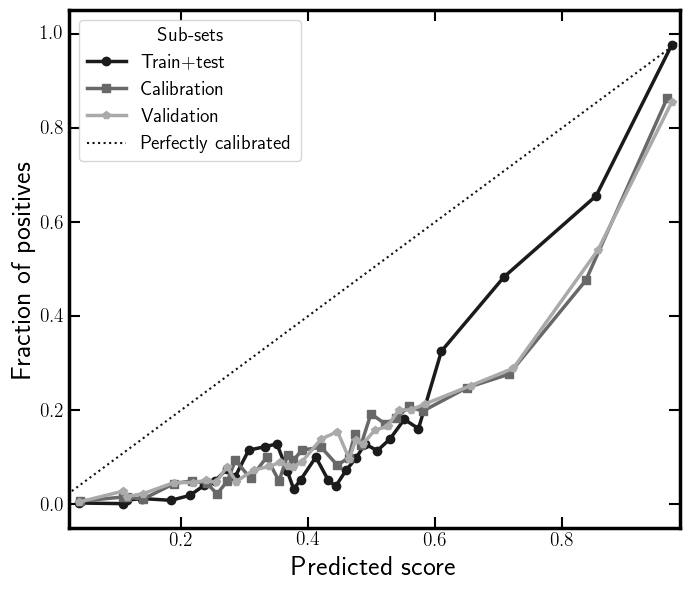

In [91]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

min_x = np.nanmin([np.nanmin(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmin(validation_prediction_clf.loc[:, 'Score_1'])])
max_x = np.nanmax([np.nanmax(train_test_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(calib_prediction_clf.loc[:, 'Score_1']),\
                   np.nanmax(validation_prediction_clf.loc[:, 'Score_1'])])

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=min_x * 0.99999, right=max_x * 1.00001)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_radio.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [92]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [93]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.84578
Area under the curve (ROC) for test       = 0.77306
Area under the curve (ROC) for train+test = 0.83340
Area under the curve (ROC) for calibraton = 0.78928
Area under the curve (ROC) for validation = 0.78698


In [94]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

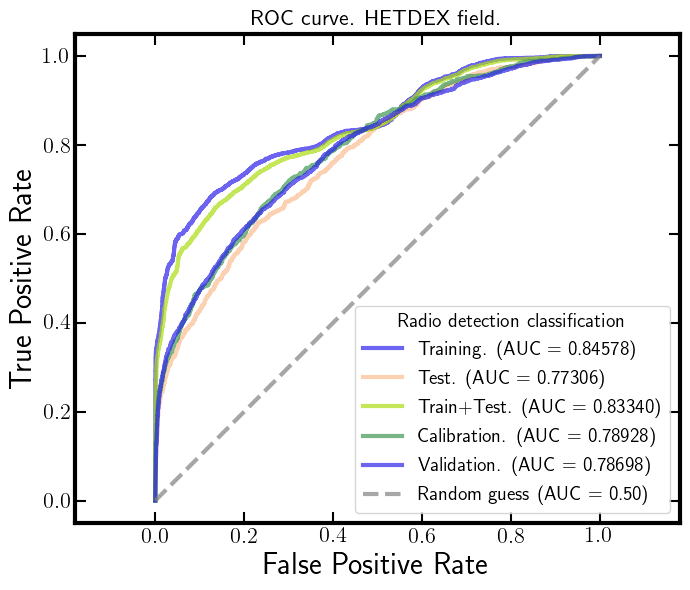

In [95]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=22)
ax1.set_ylabel('True Positive Rate', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

##### Obtain optimal thresholds from each sub-set

In [96]:
opt_thres_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_thres_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_thres_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_thres_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_thres_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [97]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_thres_train:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_thres_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_thres_train_test:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_thres_calib:.8e}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_thres_validation:.8e}')

Optimal threshold from area under the curve (ROC) for training    = 5.32999701e-01
Optimal threshold from area under the curve (ROC) for test        = 4.93025178e-01
Optimal threshold from area under the curve (ROC) for train+test  = 5.25837730e-01
Optimal threshold from area under the curve (ROC) for calibration = 4.90174694e-01
Optimal threshold from area under the curve (ROC) for validation  = 4.92293312e-01


##### Precision-Recall curve

In [98]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [99]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

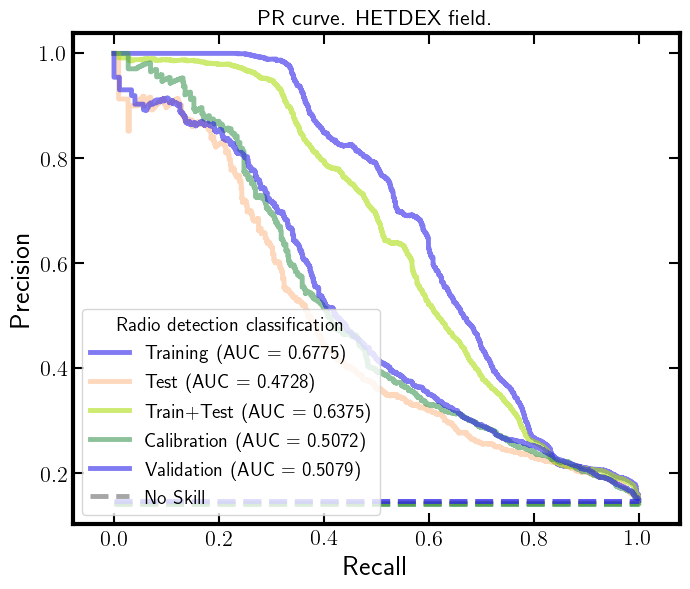

In [100]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [101]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [102]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [103]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.8e}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.8e}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.8e}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.8e}')

Optimal threshold from Precision-Recall curve for training    = 5.90654132e-01
Optimal threshold from Precision-Recall curve for test        = 5.32831362e-01
Optimal threshold from Precision-Recall curve for train+test  = 5.91015161e-01
Optimal threshold from Precision-Recall curve for calibration = 5.85771537e-01
Optimal threshold from Precision-Recall curve for validation  = 5.72485190e-01


In [104]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.59102
And, in its complete extension, is 0.5910151612


---

In [105]:
radio_pred_threshold = float(opt_t_PR_train_test) # 4.97101925e-01

In [106]:
train_prediction_clf      = pyc.predict_model(final_radio_clf, data=train_df,       probability_threshold=radio_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_radio_clf, data=test_df,        probability_threshold=radio_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_radio_clf, data=train_test_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_radio_clf, data=calibration_df, probability_threshold=radio_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_radio_clf, data=validation_df,  probability_threshold=radio_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.9009508535,0.8457752254,0.5836248013,0.6829767442,0.6294042006,0.5726461472,0.5750032489,0.6247476339


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8398093842,0.7730561028,0.4068877551,0.4381868132,0.4219576720,0.3291269741,0.3294314618,0.4204778671


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8896200304,0.8333998307,0.5530640846,0.6332603939,0.5904515778,0.5270026114,0.5286161618,0.5866829753


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8487903226,0.7892781388,0.4529032258,0.4667553191,0.4597249509,0.3718419049,0.3718989363,0.4590679109


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F_score
0,Stacking Classifier,0.8439035120,0.7869776776,0.4520958084,0.4677336087,0.4597817813,0.3685840787,0.3686568675,0.4590401947


Create confusion matrices.

In [107]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [108]:
radio_scores_array_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [109]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_array_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.6247,0.5750,0.6830,0.5836
Test,0.4205,0.3294,0.4382,0.4069
Train+Test,0.5867,0.5286,0.6333,0.5531
Calibration,0.4591,0.3719,0.4668,0.4529
Validation,0.4590,0.3687,0.4677,0.4521


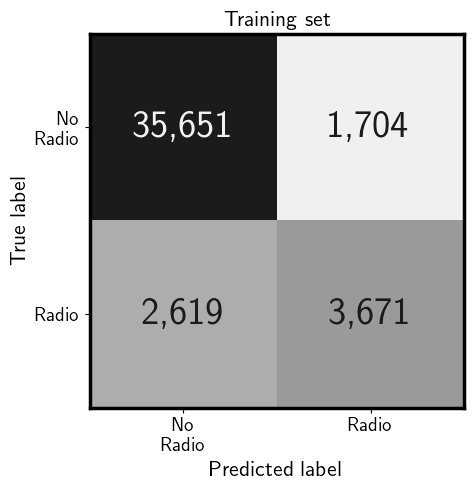

In [110]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

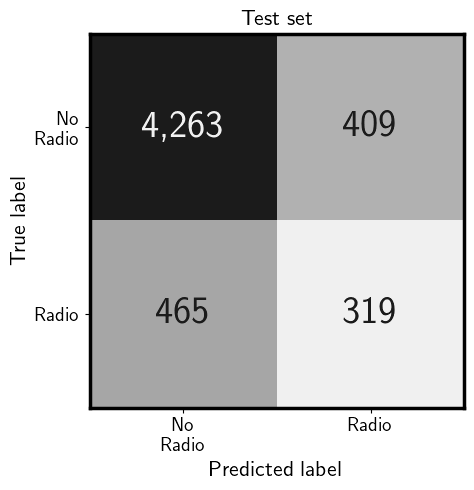

In [111]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

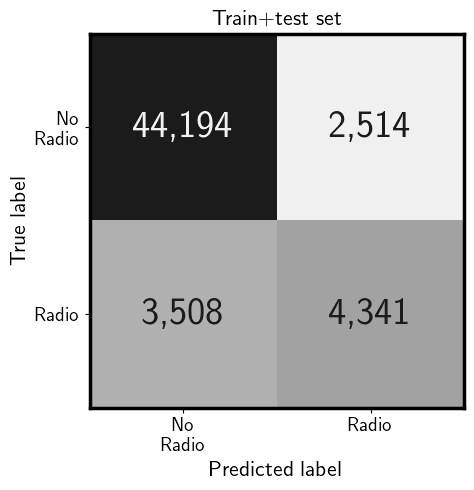

In [112]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

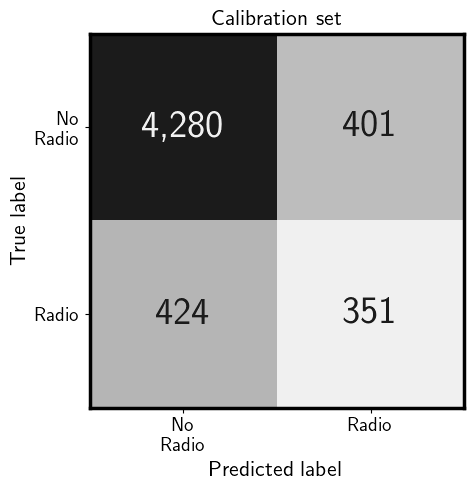

In [113]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

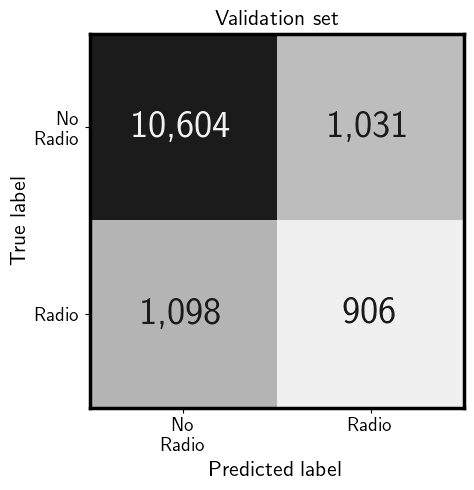

In [114]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
plt.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [115]:
print('Running data pre-processing for calibration (train+test):\n')
extended_calibration_df = gf.preprocess_data(final_radio_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (train+test):



In [116]:
if not save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])

In [117]:
if save_model_flag:
    calibrated_final_radio_clf = BetaCalibration(parameters='abm')
    calibrated_final_radio_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_radio_clf, gv.models_path + gv.cal_radio_gals_model)

In [118]:
if load_model_flag:
    calibrated_final_radio_clf = load(gv.models_path + gv.cal_radio_gals_model)

In [119]:
train_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_radio']       = calibrated_final_radio_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_radio']      = calibrated_final_radio_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_radio'] = calibrated_final_radio_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [120]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= gv.naive_radio_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= gv.naive_radio_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= gv.naive_radio_thresh).astype(int)

In [121]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [122]:
radio_scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [123]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.4861,0.5388,0.9446,0.3469
Test,0.3579,0.3760,0.7107,0.2538
Train+Test,0.4617,0.5095,0.9059,0.3286
Calibration,0.3663,0.4002,0.7704,0.2555
Validation,0.3838,0.4096,0.7644,0.2720


##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [124]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_radio'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_radio'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_radio'], pos_label=1)

AUC for PR curve

In [125]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

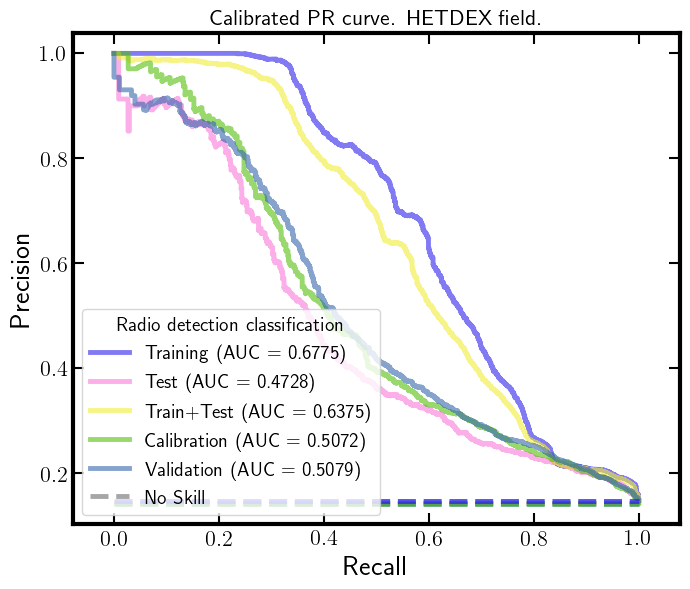

In [126]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib_cal,      recall=recall_calib_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='Radio detection classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_radio_detect_05.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [127]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [128]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [129]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.20300
Optimal threshold from Precision-Recall curve for test        = 0.16564
Optimal threshold from Precision-Recall curve for train+test  = 0.20325
Optimal threshold from Precision-Recall curve for calibration = 0.19957
Optimal threshold from Precision-Recall curve for validation  = 0.19052


In [130]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.19957
And, in its complete extension, is 0.19957242325544386


In [131]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_radio']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_radio']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_radio'] >= opt_t_PR_calib_cal).astype(int)

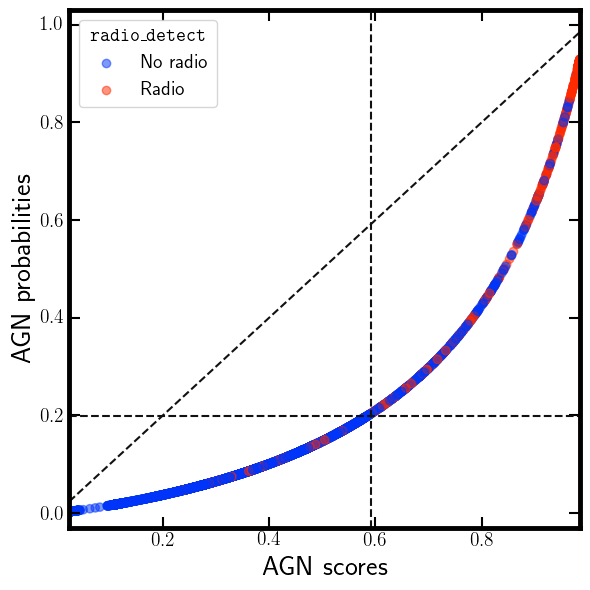

In [132]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_radio'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_xlim(left=set_to_plot.loc[:, 'Score_1'].min() * 0.99999, right=set_to_plot.loc[:, 'Score_1'].max() * 1.00001)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

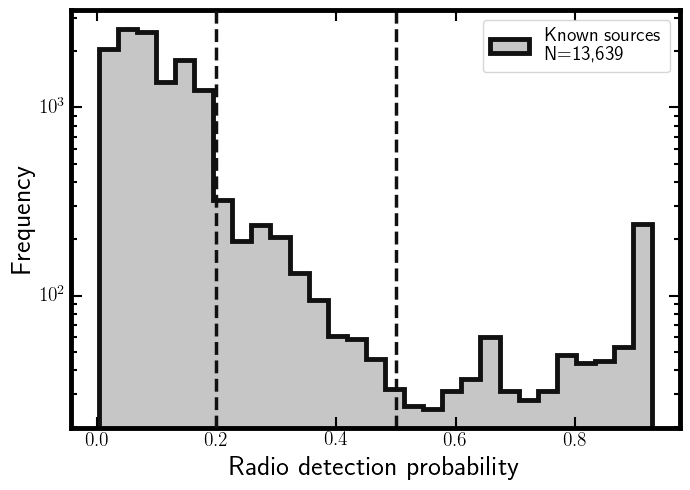

In [133]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_radio'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_radio'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_radio'])

ax1.hist(set_to_plot.loc[:, 'Prob_radio'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_radio_cal_scores_pred_AGN_known.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [134]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_radio'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

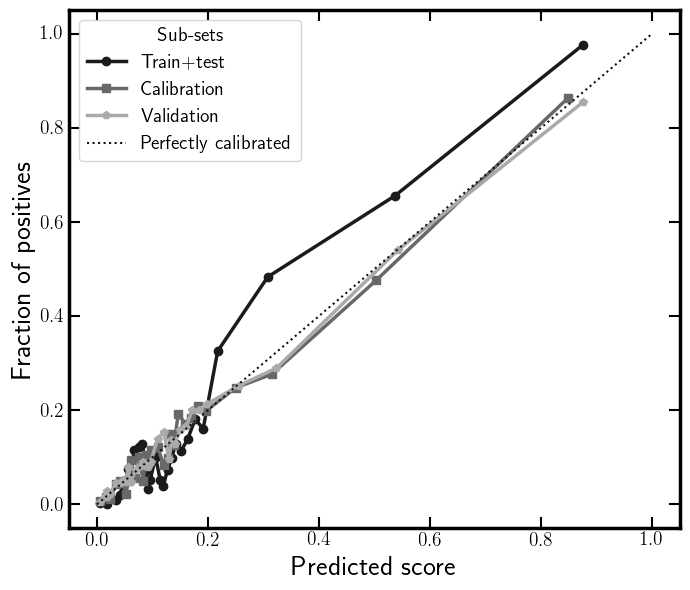

In [135]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_radio.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [136]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [137]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is -0.014 using the validation set.


Create confusion matrices.

In [138]:
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])

In [139]:
radio_scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal,\
                                              cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [140]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(radio_scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.6210,0.5661,0.6605,0.5917
Test,0.4239,0.3307,0.4341,0.4158
Train+Test,0.5846,0.5223,0.6155,0.5613
Calibration,0.4627,0.3741,0.4637,0.4619
Validation,0.4587,0.3662,0.4612,0.4566


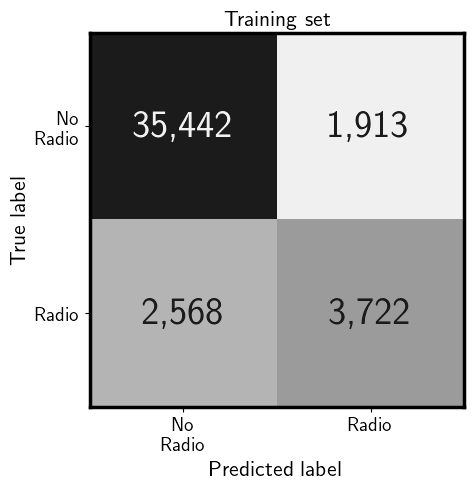

In [141]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

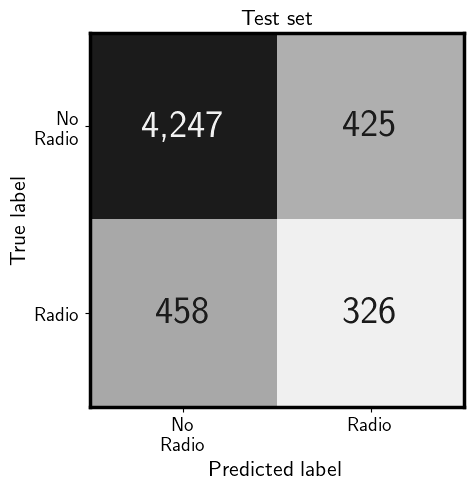

In [142]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

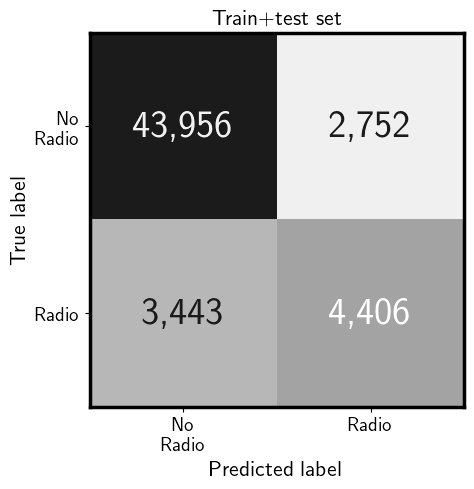

In [143]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

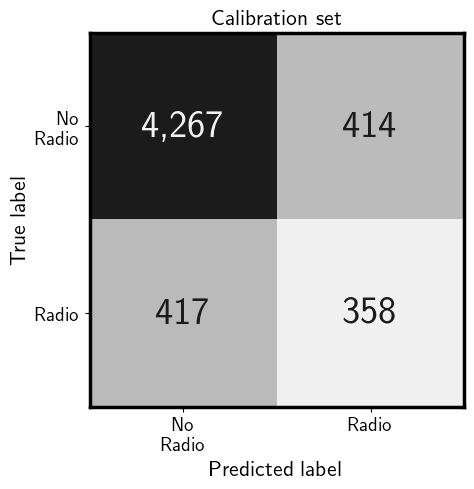

In [144]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()

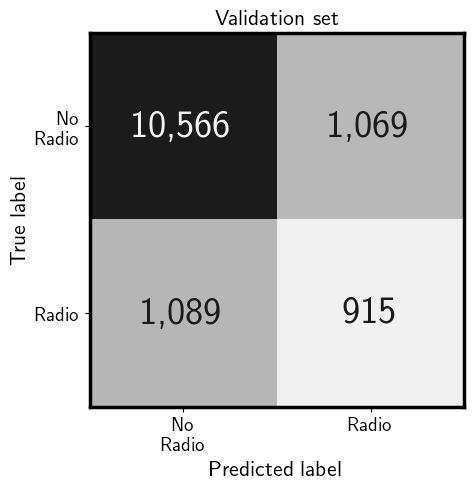

Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [145]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_radio_detect_cal.pdf', bbox_inches='tight')
plt.show()